In [1]:
#for data processing
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from math import isnan
#pd.set_option('display.max_rows', 100) # for displaying full dataset

#for feature engineering
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features): # from feature engeneering course
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
import eli5
from eli5.sklearn import PermutationImportance
import shap

#for model creation and evaluation
from sklearn.ensemble import GradientBoostingClassifier # for XGboost model
from sklearn.linear_model import LogisticRegression # for logistic regression model
from sklearn.svm import SVC # for SVM model
from sklearn.neighbors import KNeighborsClassifier # for KNN
from sklearn.naive_bayes import GaussianNB # for NB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.model_selection import cross_val_score,GridSearchCV

# for plotting the data
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

2021-09-30 09:35:11.156220: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-30 09:35:11.156345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
raw_data_train = pd.read_csv("/kaggle/input/titanic/train.csv")
raw_data_test = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
fulldata = pd.concat([raw_data_train,raw_data_test])
train_index = fulldata["Survived"].isna() == False
test_index = fulldata["Survived"].isna()
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. *Let's get familiar with the data*

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


we have missing values in both the data_sets, and the test set size is about 50% of the train set size

In [5]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

we have 7 numeric columns and 5 categorial ones.
cabin has 687 na values and age has 177, embarked has only 2

In [6]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


from the summary we can see that the test and train data features has similar statistics, we will work with the full data to fill our na values

In [9]:
cat_cols = fulldata.select_dtypes(include = "object").columns
num_cols = fulldata.select_dtypes(exclude = "object").columns
print(f"categorial columns are: {cat_cols}")
print(f"numerical columns are: {num_cols}")

categorial columns are: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')
numerical columns are: Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


In [10]:
n_uniqe = {col:fulldata[col].nunique() for col in cat_cols}
for key in n_uniqe:
    print(f"{key} has {n_uniqe[key]} unique values")

Name has 1307 unique values
Sex has 2 unique values
Ticket has 929 unique values
Cabin has 186 unique values
Embarked has 3 unique values


# 2. **Data Cleaning**

In [11]:
#for later use
fulldata["Last_Name"] = [name.split(',')[0].strip() for name in fulldata["Name"]]

In [12]:
#getting Cabin prefix when it exists
def cabin_transform(df):
    cdf = df.copy()
    cabin = []
    for x in cdf["Cabin"]:
        if type(x) != str:
            cabin.append(np.nan)
        else:
            cabin.append(x[0])
    return(cabin)
fulldata["Cabin"] = cabin_transform(fulldata)

In [13]:
last_name_cabin = pd.crosstab(fulldata["Last_Name"],fulldata["Cabin"])
(last_name_cabin != 0).sum(axis = 1).sum() - len(last_name_cabin)  #number of same last name and staying in diffrent cabin = 8
ticket_cabin = pd.crosstab(fulldata["Ticket"],fulldata["Cabin"])
(ticket_cabin != 0).sum(axis = 1).sum() - len(ticket_cabin)  #number of same last name and staying in diffrent cabin = 2
cabin_survival = pd.crosstab(fulldata["Cabin"],fulldata["Survived"],normalize="index")
cabin_survival

Survived,0.0,1.0
Cabin,,
A,0.533333,0.466667
B,0.255319,0.744681
C,0.406780,0.593220
D,0.242424,0.757576
E,0.250000,0.750000
F,0.384615,0.615385
G,0.500000,0.500000
T,1.000000,0.000000


In [14]:
print(fulldata.groupby(["Cabin"])["Fare"].mean()) # check itt
print(fulldata.groupby(["Cabin"])["Fare"].max())
print(fulldata.groupby(["Cabin"])["Fare"].min())
fulldata.groupby(["Cabin"])["Fare"].describe()

Cabin
A     41.244314
B    122.383078
C    107.926598
D     53.007339
E     54.564634
F     18.079367
G     14.205000
T     35.500000
Name: Fare, dtype: float64
Cabin
A     81.8583
B    512.3292
C    263.0000
D    113.2750
E    134.5000
F     39.0000
G     16.7000
T     35.5000
Name: Fare, dtype: float64
Cabin
A     0.0000
B     0.0000
C    25.7000
D    12.8750
E     8.0500
F     7.2292
G    10.4625
T    35.5000
Name: Fare, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Cabin,,,,,,,,
A,22.0,41.244314,20.140358,0.0000,30.1250,35.0771,50.37185,81.8583
B,65.0,122.383078,115.312993,0.0000,57.0000,82.2667,146.52080,512.3292
C,94.0,107.926598,72.912034,25.7000,52.0000,86.2896,151.55000,263.0000
D,46.0,53.007339,28.126283,12.8750,27.7208,52.5542,76.72920,113.2750
E,41.0,54.564634,37.738225,8.0500,26.2875,53.1000,79.65000,134.5000
F,21.0,18.079367,12.215124,7.2292,7.6500,13.0000,26.00000,39.0000
G,5.0,14.205000,3.416419,10.4625,10.4625,16.7000,16.70000,16.7000
T,1.0,35.500000,NaN,35.5000,35.5000,35.5000,35.50000,35.5000


In [15]:
#fill na using last name
grp_data_lname = fulldata[fulldata["Cabin"].isna() == False].groupby(["Last_Name"])["Cabin"].sum()
last_name_cabin_map = {grp_data_lname.index[i]:x[0] for i,x in enumerate (grp_data_lname)}
fulldata["Cabin"] = fulldata["Last_Name"].map(last_name_cabin_map)

#fill na using last ticket
grp_data_ticket = fulldata[fulldata["Cabin"].isna() == False].groupby(["Ticket"])["Cabin"].sum()
ticket_cabin_map = {grp_data_ticket.index[i]:x[0] for i,x in enumerate (grp_data_ticket)}
fulldata["Cabin"] = fulldata["Ticket"].map(ticket_cabin_map)

fulldata["Cabin"].fillna("Z",inplace =True) # for separating na

In [16]:
#drop unused columns
fulldata.drop(["Name","Ticket","PassengerId"],axis = 1,inplace = True) 
#filling na's
embk_mode = fulldata["Embarked"].mode()[0]
fulldata["Embarked"].fillna(embk_mode,inplace = True)
fulldata["Fare"].fillna(fulldata["Fare"].median(),inplace = True) #Fare is skewed so we will use the median

let's see age distribution before making decisions for what to do with the missing data

Survived   -0.077221
Pclass     -0.408106
Age         1.000000
SibSp      -0.243699
Parch      -0.150917
Fare        0.177528
Name: Age, dtype: float64
Pclass  Sex   
1       female    37.037594
        male      41.029272
2       female    27.499223
        male      30.815380
3       female    22.185329
        male      25.962264
Name: Age, dtype: float64


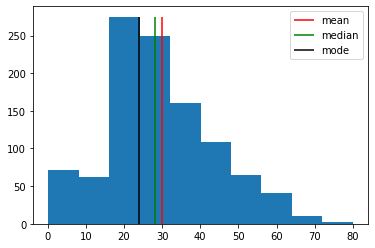

In [17]:
plt.hist(fulldata["Age"])
plt.vlines(fulldata["Age"].mean(),colors = "red",ymin = 0,ymax =275)
plt.vlines(fulldata["Age"].median(),colors = "green",ymin = 0,ymax =275)
plt.vlines(fulldata["Age"].mode(),colors = "black",ymin = 0,ymax =275)
plt.legend(["mean","median","mode"])
print(fulldata.corr()["Age"])
print(fulldata.groupby(["Pclass","Sex"])["Age"].mean()) # all other subgroups has low counts therefore the mean is irrelevant
fulldata["Age"].fillna(fulldata.groupby(["Pclass","Sex"])["Age"].transform("mean"),inplace = True)

encodeding for categorial data:

In [18]:
def label_encode_for_df(train_data,col):
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    print(f"classes encoded for {col} are {le.classes_}")
    return(train_data)

fulldata_for_plots = fulldata.copy()
for col in ["Sex","Embarked","Cabin"]:
    fulldata_for_plots = label_encode_for_df(fulldata_for_plots,col)

fulldata["Pclass"] = fulldata["Pclass"].apply(str)
fulldata = pd.concat([fulldata.drop(["Sex","Cabin","Embarked","Pclass"],axis = 1),pd.get_dummies(fulldata[["Sex","Cabin","Embarked","Pclass"]],drop_first= True)],axis = 1)

classes encoded for Sex are ['female' 'male']
classes encoded for Embarked are ['C' 'Q' 'S']
classes encoded for Cabin are ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'Z']


# 3. *now that we have cleaned the data let's make baseline models before we move to some data visualization and feature engineering*

In [19]:
# gets model and data, returns model acc
def model_score(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return(accuracy_score(y_test,y_pred))

def cv_eval_model(X,y):
    xgb_model = GradientBoostingClassifier()
    lr_model = LogisticRegression(solver='liblinear')
    svm_model = SVC(kernel="linear")
    KNN_model = KNeighborsClassifier()
    NB_model = GaussianNB()
    for model in [xgb_model,lr_model,svm_model,KNN_model,NB_model]:
        print(f"{model} cv acc is : {cross_val_score(model,X,y,cv=10,scoring=make_scorer(accuracy_score)).mean()}")

X = fulldata[train_index].drop(["Survived","Last_Name"],axis = 1)
y = fulldata[train_index].Survived
test_data = fulldata[test_index].drop(["Survived","Last_Name"],axis = 1)
cv_eval_model(X,y)

GradientBoostingClassifier() cv acc is : 0.8215480649188514
LogisticRegression(solver='liblinear') cv acc is : 0.8024968789013732
SVC(kernel='linear') cv acc is : 0.7811610486891387
KNeighborsClassifier() cv acc is : 0.7082147315855181
GaussianNB() cv acc is : 0.7665543071161048


# 4. **Data visualization**

first let's see how are data is distributed and transform some features if necessary

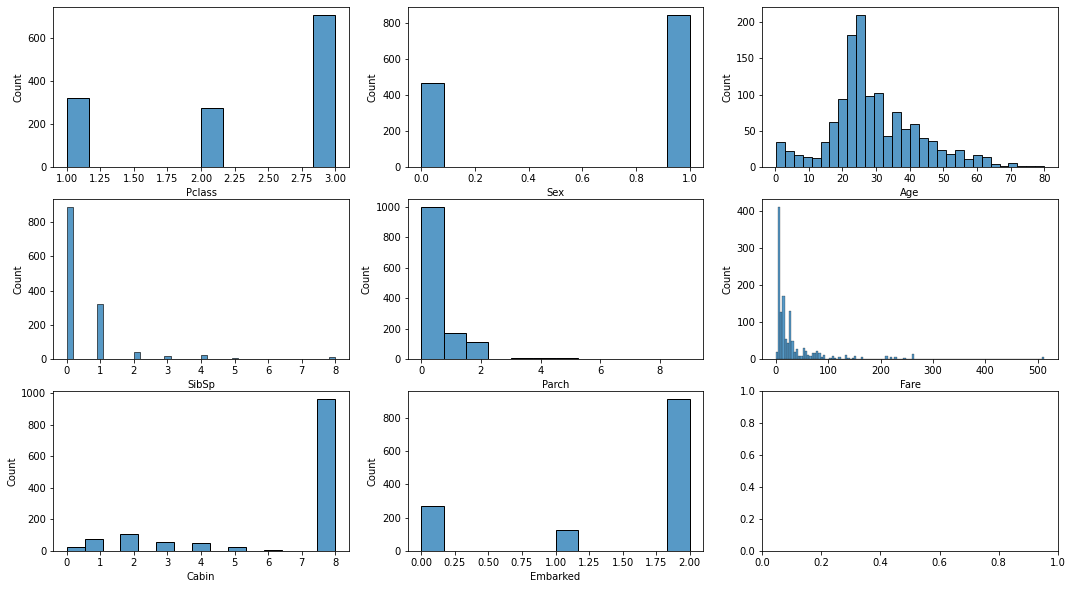

In [20]:
fig, axes = plt.subplots(3,3, figsize=(18, 10))
for i in range(len(fulldata_for_plots.columns.drop(["Survived","Last_Name"]))):
    col = fulldata_for_plots.columns.drop(["Survived","Last_Name"])[i]
    sns.histplot(fulldata_for_plots[col],ax =axes[int(np.floor(i/3)),i%3])

most of our data is nominal so there is no transformation needed for most features, Fare price is skewd so will use a transformation

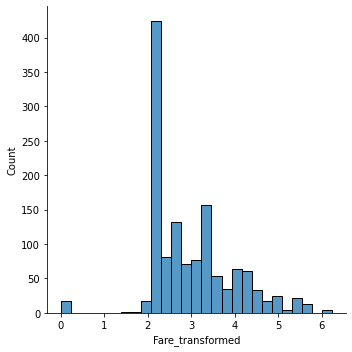

In [21]:
fulldata["Fare_transformed"] = np.log(fulldata["Fare"]+1)
fulldata.drop("Fare",axis = 1,inplace = True)

fulldata_for_plots["Fare_transformed"] = np.log(fulldata_for_plots["Fare"]+1)
fulldata_for_plots.drop("Fare",axis = 1,inplace = True)

sns.displot(fulldata_for_plots["Fare_transformed"])

Let's group age values to bins

In [22]:
age_groups = np.array([0,5,15,25,30,40,50,60,70,81])
fulldata["age_groups"] = np.digitize(fulldata["Age"],age_groups)
fulldata.drop("Age",axis = 1,inplace = True)

fulldata_for_plots["age_groups"] = np.digitize(fulldata_for_plots["Age"],age_groups)
fulldata_for_plots.drop("Age",axis = 1,inplace = True)

Let's see survival rate for each of the features values

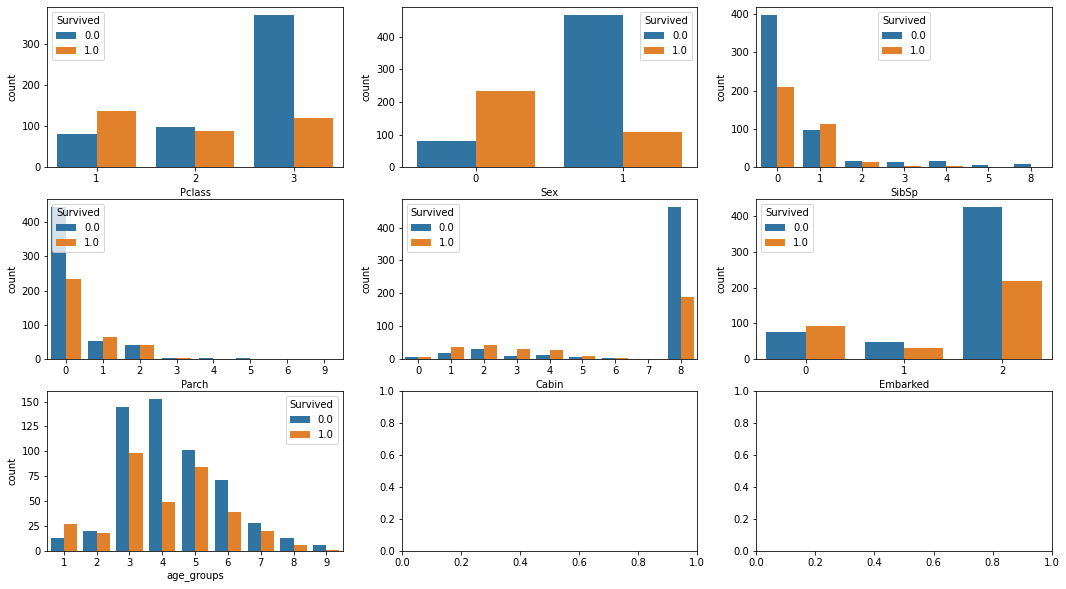

In [23]:
nominal = fulldata_for_plots.columns.drop(["Survived","Last_Name","Fare_transformed"])

fig, axes = plt.subplots(3,3, figsize=(18, 10))
for i in range(len(nominal)):
    col = nominal[i]
    sns.countplot(x=col, hue="Survived", data=fulldata_for_plots,ax = axes[int(np.floor(i/3)),i%3])

It looks like all the data is relevant, for each feature we have at least 1 class where the odss of surviving are < 50%

<AxesSubplot:>

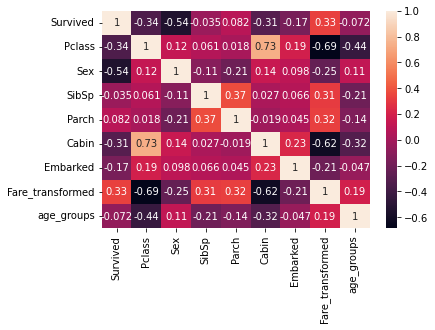

In [24]:
X = fulldata[train_index].drop(["Survived","Last_Name"],axis = 1)
y = fulldata[train_index].Survived
test_data = fulldata[test_index].drop(["Survived","Last_Name"],axis = 1)
sns.heatmap(fulldata_for_plots.corr(),annot = True)

looks like Pclass,Fare,Sex and Cabin have the best correlation although its rather low

# 5. **Feature Engineering**

**now that we have cleaned and visualzed the data let's start engineering some features**

first re evaluate our model

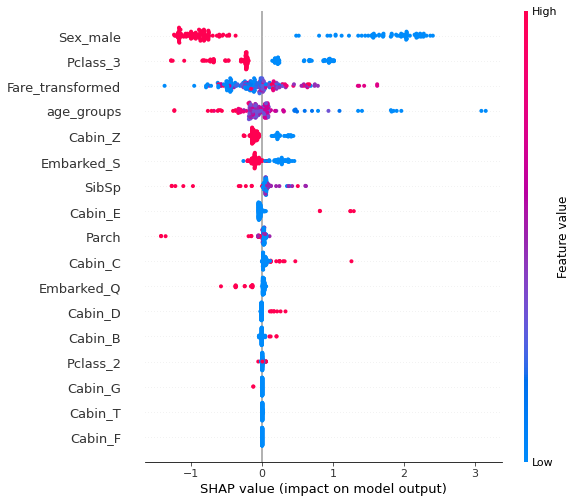

GradientBoostingClassifier() cv acc is : 0.8272034956304619
LogisticRegression(solver='liblinear') cv acc is : 0.80250936329588
SVC(kernel='linear') cv acc is : 0.7811610486891387
KNeighborsClassifier() cv acc is : 0.7857303370786517
GaussianNB() cv acc is : 0.5444319600499375


In [25]:
#shap values is used for a better understanding of what the model is doing
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 100)
xgb_model = GradientBoostingClassifier()
xgb_model.fit(X_train,y_train)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
cv_eval_model(X,y)

<AxesSubplot:xlabel='Family_members', ylabel='count'>

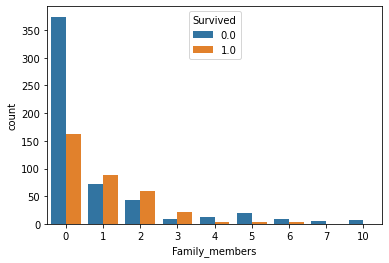

In [26]:
fulldata["Family_members"] = fulldata["Parch"] + fulldata["SibSp"]
sns.countplot(x="Family_members", hue="Survived", data=fulldata)

it looks like we can group the number of family memebers that have similar survival ratio

<AxesSubplot:xlabel='Family_members_groups', ylabel='count'>

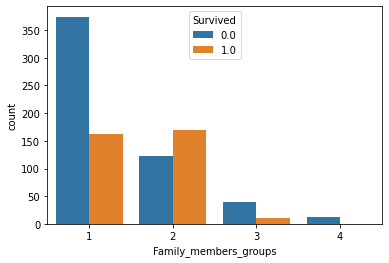

In [27]:
Family_members_groups = np.array([0,1,4,7,11])
fulldata["Family_members_groups"] = np.digitize(fulldata["Family_members"],Family_members_groups)
fulldata.drop(["Family_members"],axis = 1,inplace = True)

sns.countplot(x="Family_members_groups", hue="Survived", data=fulldata)

Now that we have engineered some features let's see which ones are more important, we will investigate for the XGB model

In [28]:
X = fulldata[train_index].drop(["Survived","Last_Name"],axis = 1)
cv_eval_model(X,y)
print(make_mi_scores(X, y, X.dtypes == "int64"))

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 100)
xgb_model = GradientBoostingClassifier()
xgb_model.fit(X_train,y_train)
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test,n_iter=20)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),top  = 20)

GradientBoostingClassifier() cv acc is : 0.826079900124844
LogisticRegression(solver='liblinear') cv acc is : 0.7991510611735331
SVC(kernel='linear') cv acc is : 0.7822846441947566
KNeighborsClassifier() cv acc is : 0.7778901373283396
GaussianNB() cv acc is : 0.5567790262172284
Sex_male                 0.159146
Fare_transformed         0.137145
Cabin_Z                  0.062519
Family_members_groups    0.045797
Cabin_C                  0.035381
Pclass_3                 0.032532
SibSp                    0.025047
Parch                    0.021964
Cabin_T                  0.021651
Embarked_Q               0.019854
Cabin_E                  0.016237
Cabin_B                  0.011287
Cabin_D                  0.003192
Cabin_G                  0.000555
Cabin_F                  0.000000
Embarked_S               0.000000
Pclass_2                 0.000000
age_groups               0.000000
Name: MI Scores, dtype: float64


Weight,Feature
0.1888 ± 0.0444,Sex_male
0.1196 ± 0.0230,Pclass_3
0.0402 ± 0.0295,Fare_transformed
0.0346 ± 0.0476,age_groups
0.0257 ± 0.0114,Family_members_groups
0.0078 ± 0.0055,SibSp
0.0078 ± 0.0134,Embarked_S
0.0056 ± 0.0071,Embarked_Q
0.0011 ± 0.0148,Cabin_Z
0 ± 0.0000,Cabin_T


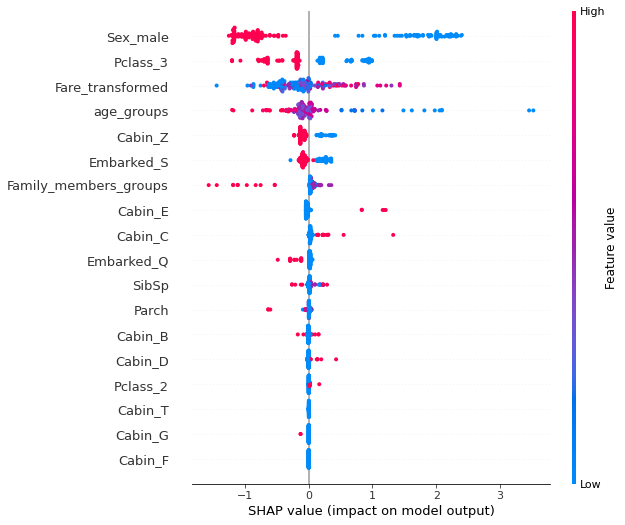

In [29]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Looks like Parch and SibSp have no importance to our model, let's keep the more important features

In [30]:
X = fulldata[train_index].drop(["SibSp","Parch","Survived","Last_Name"],axis = 1)
cv_eval_model(X,y)

GradientBoostingClassifier() cv acc is : 0.829450686641698
LogisticRegression(solver='liblinear') cv acc is : 0.8036204744069912
SVC(kernel='linear') cv acc is : 0.7833832709113608
KNeighborsClassifier() cv acc is : 0.7992259675405743
GaussianNB() cv acc is : 0.5915355805243445


In [31]:
xgb_model = GradientBoostingClassifier()
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 100)
xgb_model.fit(X_train,y_train)
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test,n_iter=20)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),top  = 20)

Weight,Feature
0.1855 ± 0.0259,Sex_male
0.0927 ± 0.0089,Pclass_3
0.0469 ± 0.0321,age_groups
0.0458 ± 0.0295,Fare_transformed
0.0279 ± 0.0100,Family_members_groups
0.0156 ± 0.0130,Embarked_S
0.0067 ± 0.0109,Embarked_Q
0.0045 ± 0.0130,Cabin_C
0 ± 0.0000,Pclass_2
0 ± 0.0000,Cabin_T


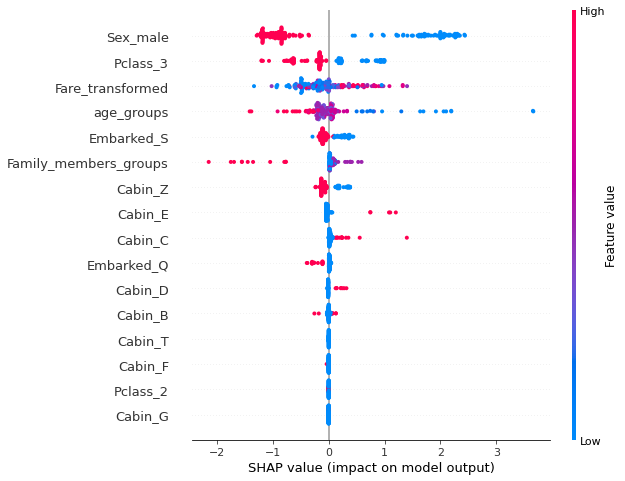

In [32]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [33]:
test_data = fulldata[test_index].drop(["SibSp","Parch","Survived","Last_Name"],axis = 1)
cv_eval_model(X,y)

xgb_model = GradientBoostingClassifier()
lr_model = LogisticRegression(solver='liblinear')
svm_model = SVC(kernel="linear")
KNN_model = KNeighborsClassifier()

estimator = [('xgb_model',xgb_model),('lr_model',lr_model),('svm_model',svm_model),('KNN_model',KNN_model)]
vot = VotingClassifier(estimators = estimator, voting ='hard')
vot.fit(X,y)

## delete
y_pred = vot.predict(X_test)
print(accuracy_score(y_test, y_pred))

y_pred_sbu = vot.predict(test_data)
sub = pd.DataFrame({"Survived":y_pred_sbu.astype(int),"PassengerId" : raw_data_test["PassengerId"]})
sub.to_csv('submission.csv', index=False)

GradientBoostingClassifier() cv acc is : 0.829450686641698
LogisticRegression(solver='liblinear') cv acc is : 0.8036204744069912
SVC(kernel='linear') cv acc is : 0.7833832709113608
KNeighborsClassifier() cv acc is : 0.7992259675405743
GaussianNB() cv acc is : 0.5915355805243445
0.8491620111731844


# **6. Lets tune our paramaters!**

In [34]:
# this is the code for the GridSearchCV I used
def find_best_params_gs(clf,param_grid,X, y):
    gcv = GridSearchCV(clf,param_grid = param_grid,scoring =make_scorer(accuracy_score),cv = 10,verbose = 1,n_jobs = -1)
    gcv.fit(X_train,y_train)
    print(f"{clf} model best params are: {gcv.best_params_}, and score is {gcv.best_score_}")
    return(gcv.best_params_,gcv.best_score_)
#KNN_param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19],'weights':['uniform', 'distance'],'algorithm':['ball_tree', 'kd_tree','brute']}
#svm_param_grid = {'kernel':['linear','poly','sigmoid'],'degree':[2,3],'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1]}#

#lr_param_grid = {'penalty':["l1","l2", "none"],'C': [0.001,0.01,0.1,1,10,100],"fit_intercept":[True,False],"solver":['newton-cg', 'lbfgs', 'liblinear']}

#xgb_param_grid = {"learning_rate":[0.1,0.5],"n_estimators":[50,100,250,500,1000,2500],"subsample":[0.6,0.8,1],'max_depth': [3,4,5,6,7,8,9,10]}
#knn_parm,knn_score = find_best_params_gs(KNeighborsClassifier(),KNN_param_grid,X, y)
#svm_parm,svm_score = find_best_params_gs(SVC(),svm_param_grid,X, y)
#lr_parm,lr_score = find_best_params_gs(LogisticRegression(),lr_param_grid,X, y)
#xgb_parm,xgb_score = find_best_params_gs(GradientBoostingClassifier(),xgb_param_grid,X, y)

In [35]:
knn_parm = {'algorithm': 'ball_tree', 'n_neighbors': 13}
lr_parm = {'C': 1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
svm_parm = {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
xgb_parm = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}

xgb_model = GradientBoostingClassifier(**xgb_parm)
lr_model = LogisticRegression(**lr_parm)
svm_model = SVC(**svm_parm)
KNN_model = KNeighborsClassifier(**knn_parm)
estimator = [('xgb_model',xgb_model),('lr_model',lr_model),('svm_model',svm_model),('KNN_model',KNN_model)]
vot = VotingClassifier(estimators = estimator, voting ='hard')
vot.fit(X,y)


for model in [xgb_model,lr_model,svm_model,KNN_model]:
    print(f"{model} cv acc after tune is : {cross_val_score(model,X,y,cv=10,scoring=make_scorer(accuracy_score)).mean()}")

y_pred = vot.predict(X_test)
print(f"voting acc after tune is:{accuracy_score(y_test, y_pred)}")

y_pred = vot.predict(test_data)
sub = pd.DataFrame({"Survived":y_pred_sbu.astype(int),"PassengerId" : raw_data_test["PassengerId"]})
sub.to_csv('submission1.csv', index=False)


GradientBoostingClassifier(n_estimators=50, subsample=1) cv acc after tune is : 0.8305742821473159
LogisticRegression(C=1, solver='newton-cg') cv acc after tune is : 0.8103495630461923
SVC(C=1, degree=2, gamma=0.1, kernel='poly') cv acc after tune is : 0.8148064918851435
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=13) cv acc after tune is : 0.8058551810237203
voting acc after tune is:0.8379888268156425


let's do some hyperparamater tuning